<a href="https://colab.research.google.com/github/Itsuki-Hamano123/LIME_prac/blob/master/Tutorial_Image_Classification_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/My Drive/機械学習練習/lime/lime/doc/notebooks

/content/drive/My Drive/機械学習練習/lime/lime/doc/notebooks


In [0]:
ls

 data/
'Lime - basic usage, two class case.ipynb'
'Lime - multiclass.ipynb'
'Lime with Recurrent Neural Networks.ipynb'
'Submodular Pick examples.ipynb'
'Tutorial -cat_dog_ Image Classification Keras.ipynb'
'Tutorial - continuous and categorical features.ipynb'
'Tutorial - Faces and GradBoost.ipynb'
 Tutorial_H2O_continuous_and_cat.ipynb
'Tutorial - Image Classification Keras.ipynb'
'Tutorial - images.ipynb'
'Tutorial - MNIST and RF.ipynb'
'Using lime for regression.ipynb'


In [0]:
#不明なオブジェクトの中身を見る際の関数宣言
import types


def explain(item, shows_private=False, shows_method=False):
    '''
    与えた python オブジェクトの詳細を表示します。
    '''
    print('EXPLAIN ------------------')
    print(item)
    print(type(item))
    print('ATTRIBUTES:')
    for d in dir(item):
        if d == 'type':
            continue
        if not shows_private and d.startswith('_'):
            continue
        attr = getattr(item, d)
        if not shows_method and (
                isinstance(attr, types.MethodType) or
                isinstance(attr, types.BuiltinMethodType) or
                isinstance(attr, types.CoroutineType) or
                isinstance(attr, types.FunctionType) or
                isinstance(attr, types.BuiltinFunctionType) or
                isinstance(attr, types.GeneratorType)
        ):
            continue
        print('{}:\t{}'.format(d, attr))

#kerasのCNNモデルの予測結果の説明

Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [0]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)#Notebook run using keras: 2.2.4

Using TensorFlow backend.


Notebook run using keras: 2.2.4


## インセプションモデルを使う
（# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools
）

In [0]:
#インセプションv3のインスタンス化
inet_model = inc_net.InceptionV3()

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 3s 0us/step


In [0]:
#インセプションで予測するための画像整形
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

### インセプションの予測結果（Let's see the top 5 prediction for some image）

40960/35363 [==================================] - 0s 2us/step
('n03942813', 'ping-pong_ball', 0.24398789)
('n07747607', 'orange', 0.19385453)
('n02123045', 'tabby', 0.1727749)
('n02123159', 'tiger_cat', 0.06723416)
('n02124075', 'Egyptian_cat', 0.06370907)


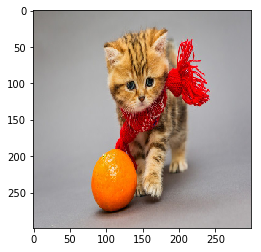

In [0]:
#画像整形関数呼び出し
images = transform_img_fn([os.path.join('data','cat_orange.jpg')])
#images = transform_img_fn([os.path.join('data','ケビン/bear_dog_girl.jpg')])
#入力画像の表示
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
#画像の予測
preds = inet_model.predict(images)
#予測結果の表示（WordNetID,カテゴリ名,確信度）
for x in decode_predictions(preds)[0]:
    print(x)

#説明の開始
limeライブラリを実際に使っていく
（## Explanation
Now let's get an explanation）

In [0]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [0]:
#limeのインスタンス化
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)
ここで設定するhide_color=0は関係ないとこを、後々に灰色で出すため

予測の説明を生成します。

最初に、インスタンスから特徴をランダムに摂動させることによって近傍データを生成します（__data_inverseを参照）。次に、この近傍データについて局所的に重み付けされた線形モデルを学習して、各クラスを説明可能な方法で説明します

In [0]:
%%time
#limeに入力画像をsetし、説明する際に必要なもろもろのオプションを設定する
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)
#explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, num_samples=1000)

CPU times: user 11.4 s, sys: 2.41 s, total: 13.8 s
Wall time: 13.2 s


In [0]:
#object内の各ラベルの値を確認する用
#print(explain(explanation))
#格納されているtop_labelの確認
print(explanation.top_labels)

[722, 950, 281, 282, 285]


Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 29s

#予測結果（トップ）の説明
### Now let's see the explanation for the top class ( Black Bear)

superpixelは、距離的・色的に近い画素をひとまとまりにとらえたものです。予測結果（引数ラベル）に対して、影響を与えたsuperpixelを5つ表示し、それ以外は灰色にする（superpixelについて：https://techblog.nhn-techorus.com/archives/7793）（We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden）

In [0]:
from skimage.segmentation import mark_boundaries

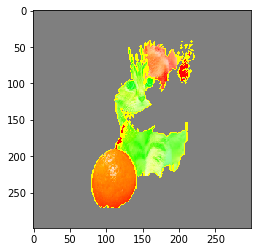

In [0]:
#Black Bear（引数ラベル）の予測に影響したsuperpixelの内、上位5件を表示。それ以外の領域は灰色表示（295以外はラベル無いよと言われる）
#返り値のtempが3次元的、maskが二次元的な情報
temp, mask = explanation.get_image_and_mask(281, positive_only=False, num_features=7, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

hide_rest=Falseにすると元画像も表示できる
（Or with the rest of the image present:）

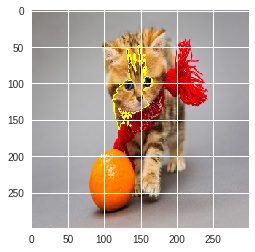

In [0]:
temp, mask = explanation.get_image_and_mask(722, positive_only=True, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


ラベルの予測に影響を与えた上位superpixelの内、ネガティブ（予測に悪い影響を与える）だったかも分かる
（We can also see the 'pros and cons' (pros in green, cons in red)）

CPU times: user 29.3 ms, sys: 788 µs, total: 30.1 ms
Wall time: 29.7 ms


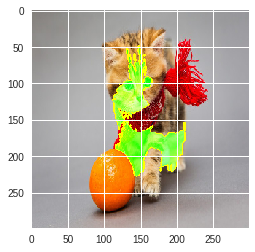

In [0]:
%%time
temp, mask = explanation.get_image_and_mask(281, positive_only=False, num_features=3, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

num_featuresの内、一定の閾値を超える影響度を与えたpixelのみ表示（簡単にポジティブだけ取り除ける）
ネガティブは、戻り値で処理する必要あり
（Or the pros and cons that have weight at least 0.1）

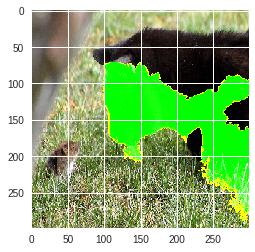

In [0]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

第④位のヴォンバットのみに対する説明を見ていく（Let's see the explanation for Wombat）

Most positive towards wombat:

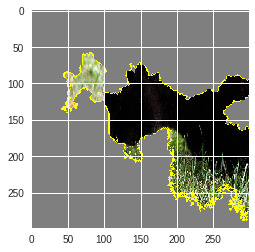

In [0]:
temp, mask = explanation.get_image_and_mask(106, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

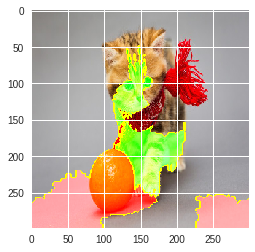

In [0]:
temp, mask = explanation.get_image_and_mask(281, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
